In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nvidia-historical-market-data-2023-2024-for-ml/Report-Nvidia Stock Prediction-MultivariatePCAFactor Analysis.pdf
/kaggle/input/nvidia-historical-market-data-2023-2024-for-ml/NVIDIA Historical Market Data 01-04-2023 - 05-13-2024 - NVDA.csv
/kaggle/input/nvidia-historical-market-data-2023-2024-for-ml/NVIDIA Historical Market Data 01-04-2023 - 05-13-2024.xlsx


In [19]:
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


This dataset organized stock market data from 01-04-2023 to 05-13-2024 from Yahoo Finance.

 The key idea is to utilize historical stock market dataset to predict ****Next Day adjusted close price**** by using various variables.
Aim is to figure out the feasibility to predict stock market adjusted closing price for the trendy AI stock NVIDIA and filter out the most important indicator of stock price prediction.



In [20]:
df = pd.read_csv('../input/nvidia-historical-market-data-2023-2024-for-ml/NVIDIA Historical Market Data 01-04-2023 - 05-13-2024 - NVDA.csv',header=None)

df.columns = df.iloc[1]

# Drop the first two rows from the DataFrame
df = df[2:]

# Reset the index without keeping the old index column
df.reset_index(drop=True, inplace=True)



In [21]:
df.head()

1,Date,Open,Range,Volume,Log_Volume,Return_Percentage,3_Day_Avg_AdjClose(Delay),PriorDay_AdjClose,Adj Close
0,2023-01-06,144.74,9.76,40504400,7.61,4.164%,144.3591717,142.58,148.52
1,2023-01-09,152.84,9.15,50423100,7.70,5.175%,146.171621,148.52,156.20
2,2023-01-10,155.07,4.90,38410100,7.58,1.798%,149.1001843,156.20,159.01
3,2023-01-11,158.40,4.65,35328500,7.55,0.578%,154.5774943,159.01,159.93
4,2023-01-12,161.00,11.45,55140900,7.74,3.187%,158.3822887,159.93,165.03


In [22]:
df.tail()

1,Date,Open,Range,Volume,Log_Volume,Return_Percentage,3_Day_Avg_AdjClose(Delay),PriorDay_AdjClose,Adj Close
348,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
349,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
350,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
351,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN
352,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN


Let's check for N/A values

In [59]:
df.isna().sum()

1
Date                         14
Open                         14
Range                        14
Volume                       14
Log_Volume                   14
Return_Percentage            14
3_Day_Avg_AdjClose(Delay)     0
PriorDay_AdjClose            14
Adj Close                    14
dtype: int64

In [20]:
df.shape

(353, 9)

In [30]:
df.dtypes

1
Date                         object
Open                         object
Range                        object
Volume                       object
Log_Volume                   object
Return_Percentage            object
3_Day_Avg_AdjClose(Delay)    object
PriorDay_AdjClose            object
Adj Close                    object
dtype: object

Since we have time series data lets fill Nan values with the help of interpolation

In [23]:
# Convert columns to appropriate data types
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Range'] = pd.to_numeric(df['Range'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')
df['Log_Volume'] = pd.to_numeric(df['Log_Volume'], errors='coerce')
df['Return_Percentage'] = df['Return_Percentage'].str.rstrip('%').astype('float') / 100.0
df['3_Day_Avg_AdjClose(Delay)'] = pd.to_numeric(df['3_Day_Avg_AdjClose(Delay)'], errors='coerce')
df['PriorDay_AdjClose'] = pd.to_numeric(df['PriorDay_AdjClose'], errors='coerce')
df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')


In [24]:
df.dtypes

1
Date                         datetime64[ns]
Open                                float64
Range                               float64
Volume                              float64
Log_Volume                          float64
Return_Percentage                   float64
3_Day_Avg_AdjClose(Delay)           float64
PriorDay_AdjClose                   float64
Adj Close                           float64
dtype: object

In [6]:
df.head()

1,Date,Open,Range,Volume,Log_Volume,Return_Percentage,3_Day_Avg_AdjClose(Delay),PriorDay_AdjClose,Adj Close
0,2023-01-06,144.74,9.76,40504400.0,7.61,0.04164,144.359172,142.58,148.52
1,2023-01-09,152.84,9.15,50423100.0,7.70,0.05175,146.171621,148.52,156.20
2,2023-01-10,155.07,4.90,38410100.0,7.58,0.01798,149.100184,156.20,159.01
3,2023-01-11,158.40,4.65,35328500.0,7.55,0.00578,154.577494,159.01,159.93
4,2023-01-12,161.00,11.45,55140900.0,7.74,0.03187,158.382289,159.93,165.03


In [25]:
# Drop rows where the 'Date' column is NaN
df_cleaned = df.dropna(subset=['Date'])

# Check if there are still any NaN values in the 'Date' column
print(df_cleaned.isna().sum())

# Display the cleaned DataFrame
print(df_cleaned)


1
Date                         0
Open                         0
Range                        0
Volume                       0
Log_Volume                   0
Return_Percentage            0
3_Day_Avg_AdjClose(Delay)    0
PriorDay_AdjClose            0
Adj Close                    0
dtype: int64
1         Date    Open  Range      Volume  Log_Volume  Return_Percentage  \
0   2023-01-06  144.74   9.76  40504400.0        7.61            0.04164   
1   2023-01-09  152.84   9.15  50423100.0        7.70            0.05175   
2   2023-01-10  155.07   4.90  38410100.0        7.58            0.01798   
3   2023-01-11  158.40   4.65  35328500.0        7.55            0.00578   
4   2023-01-12  161.00  11.45  55140900.0        7.74            0.03187   
..         ...     ...    ...         ...         ...                ...   
334 2024-05-07  910.98  94.56  43734200.0        7.64           -0.01721   
335 2024-05-08  894.83  17.74  32572100.0        7.51           -0.00157   
336 2024-05-09  905.29

In [7]:
# df_interpolated = df.interpolate()
# # Check for any remaining NaNs
# print(df_interpolated.isna().sum())

1
Date                         0
Open                         0
Range                        0
Volume                       0
Log_Volume                   0
Return_Percentage            0
3_Day_Avg_AdjClose(Delay)    0
PriorDay_AdjClose            0
Adj Close                    0
dtype: int64


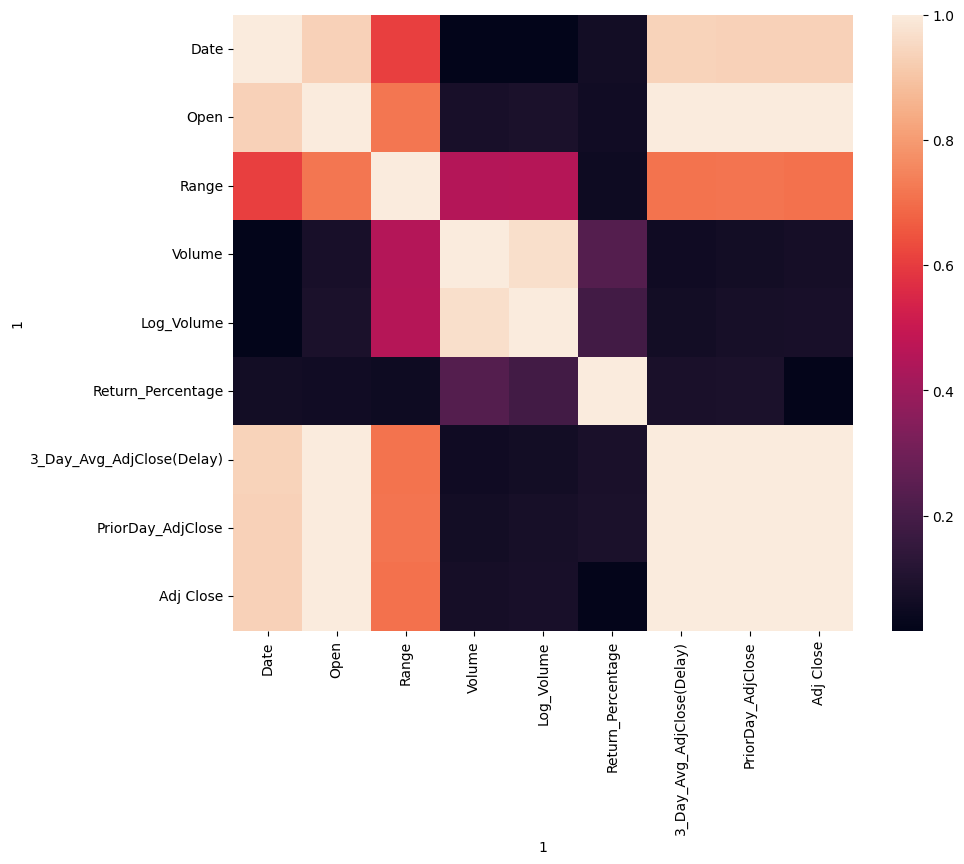

In [26]:
plt.figure(figsize = (10,8))
sns.heatmap(df_cleaned.corr().abs())    # To see the correlations
plt.show()

Open, Range, and PriorDay_AdjClose: These variables show a higher correlation with the Adj Close price.
Volume, Log_Volume, and Return_Percentage: These variables show some correlation with each other and with other features but not strongly with Adj Close.
3_Day_Avg_AdjClose(Delay): Shows a strong positive correlation with the Adj Close price, indicating it could be a significant predictor.


****Feature Selection:****

We'll focus on features that have a higher correlation with the target variable (Adj Close), such as Open, Range, PriorDay_AdjClose, and 3_Day_Avg_AdjClose(Delay).


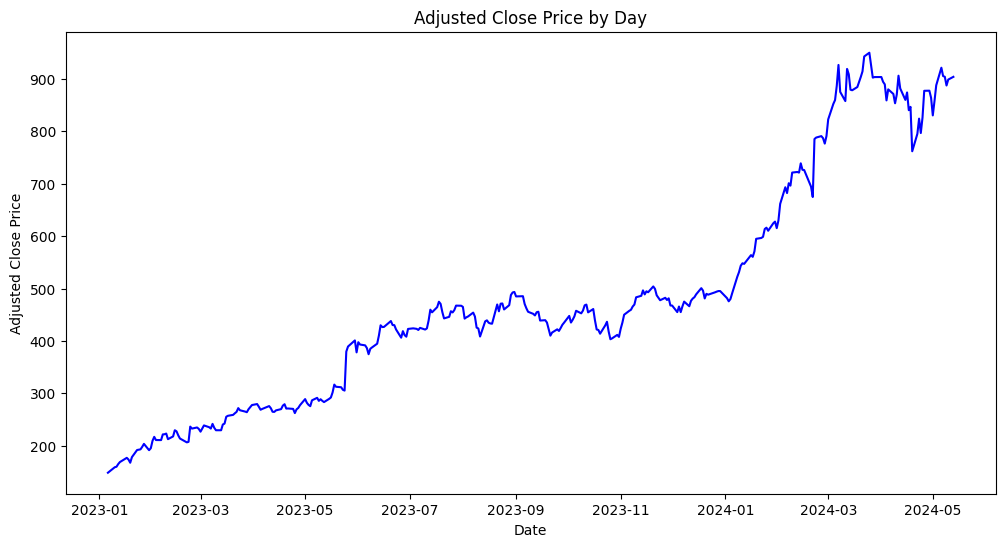

In [27]:
import matplotlib.pyplot as plt

# Set Date as the index 
df_cleaned.set_index('Date', inplace=True)

# Plot the Adjusted Close price as a line plot
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned.index, df_cleaned['Adj Close'], linestyle='-', marker='', color='b')
plt.title('Adjusted Close Price by Day')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()


The Adjusted Close price shows an overall upward trend from January 2023 to May 2024.
There are noticeable periods of increased volatility, especially towards the end of the period.

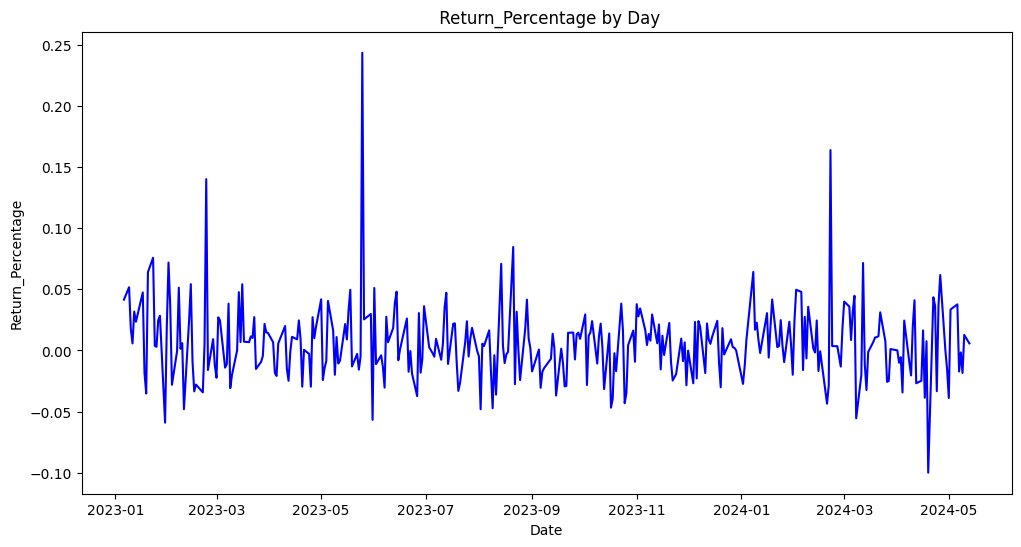

In [28]:
# Return_percentage by day
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned.index, df_cleaned['Return_Percentage'], linestyle='-', marker='', color='b')
plt.title(' Return_Percentage by Day')
plt.xlabel('Date')
plt.ylabel('Return_Percentage')
plt.show()


****1. Linear Regression****

In [29]:
# Define features and target variable
features = ['Open', 'Range', 'PriorDay_AdjClose', '3_Day_Avg_AdjClose(Delay)']
target = 'Adj Close'

# Split the data into training and testing sets
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 199.6825009280894


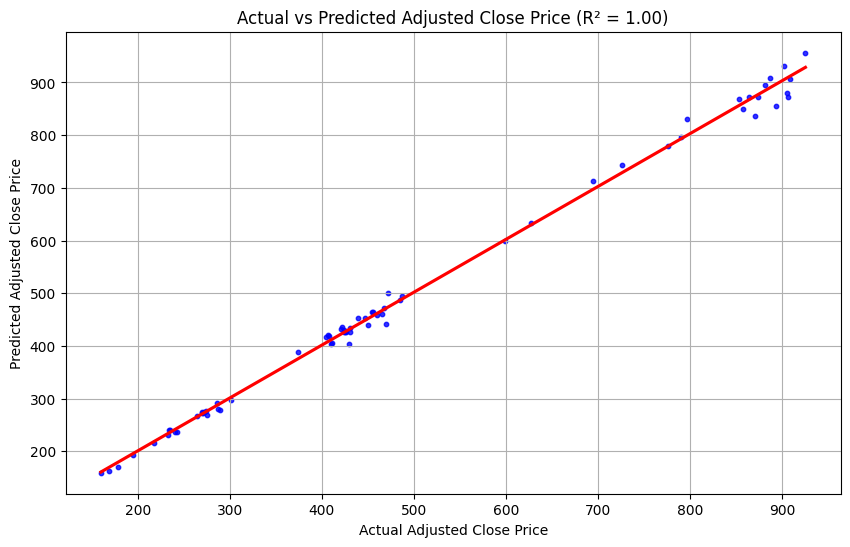

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Assuming y_test and y_pred are your actual and predicted values

# Calculate R-squared for better understanding
r2 = r2_score(y_test, y_pred)

# Create a DataFrame for seaborn plotting
df_plot = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.regplot(x='Actual', y='Predicted', data=df_plot, ci=None, scatter_kws={"s": 10, "color": "blue"}, line_kws={"color": "red"})
plt.xlabel('Actual Adjusted Close Price')
plt.ylabel('Predicted Adjusted Close Price')
plt.title(f'Actual vs Predicted Adjusted Close Price (R² = {r2:.2f})')
plt.grid(True)
plt.show()


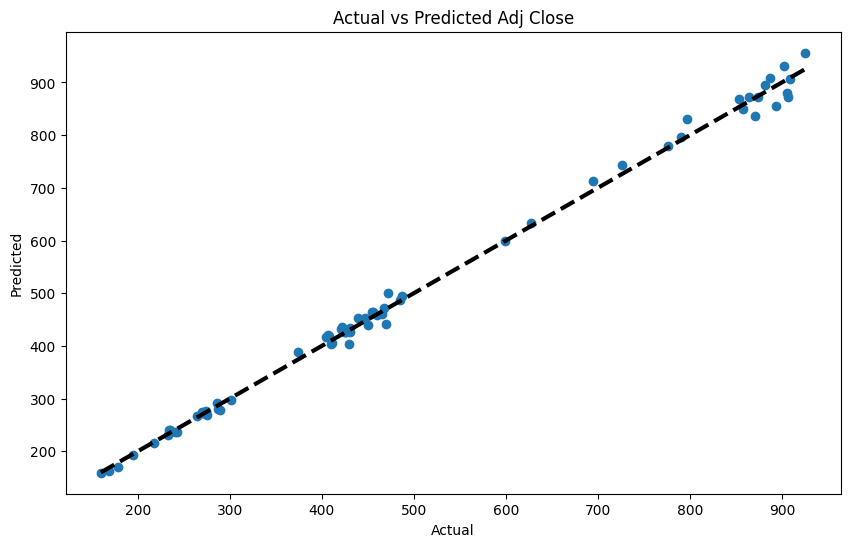

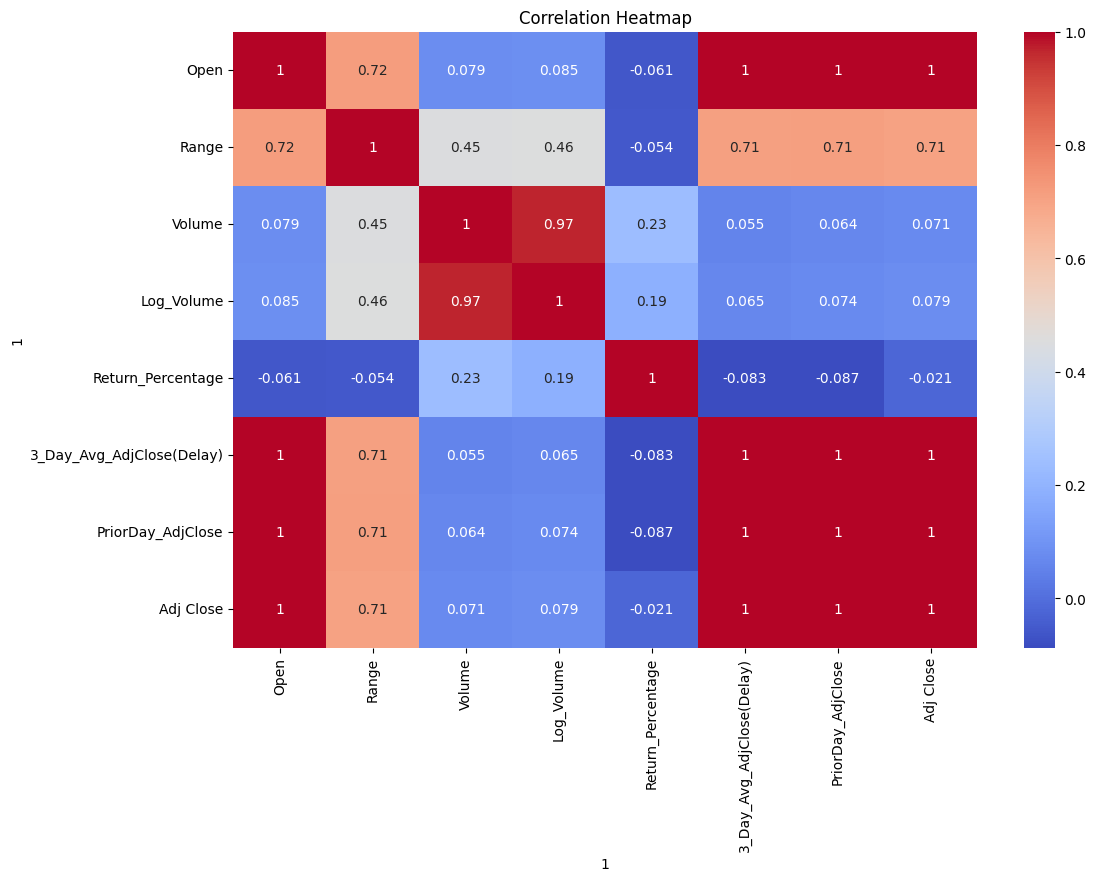

In [31]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Adj Close')
plt.show()

# Display the correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

****2. ARIMA****

In [32]:
df_cleaned.head()

1,Open,Range,Volume,Log_Volume,Return_Percentage,3_Day_Avg_AdjClose(Delay),PriorDay_AdjClose,Adj Close
Date,,,,,,,,
2023-01-06,144.74,9.76,40504400.0,7.61,0.04164,144.359172,142.58,148.52
2023-01-09,152.84,9.15,50423100.0,7.70,0.05175,146.171621,148.52,156.20
2023-01-10,155.07,4.90,38410100.0,7.58,0.01798,149.100184,156.20,159.01
2023-01-11,158.40,4.65,35328500.0,7.55,0.00578,154.577494,159.01,159.93
2023-01-12,161.00,11.45,55140900.0,7.74,0.03187,158.382289,159.93,165.03


In [38]:
df_cleaned.isna().sum()

1
Open                         0
Range                        0
Volume                       0
Log_Volume                   0
Return_Percentage            0
3_Day_Avg_AdjClose(Delay)    0
PriorDay_AdjClose            0
Adj Close                    0
dtype: int64

In [41]:
# Infer the frequency of the DateTime index
inferred_freq = pd.infer_freq(df_cleaned.index)
print(f'Inferred frequency: {inferred_freq}')
df_cleaned = df_cleaned.asfreq('B')
# Fill NaN values with the mean of each column
df_filled = df_cleaned.fillna(df_cleaned.mean())


Inferred frequency: None


In [42]:
df_filled.isna().sum()

1
Open                         0
Range                        0
Volume                       0
Log_Volume                   0
Return_Percentage            0
3_Day_Avg_AdjClose(Delay)    0
PriorDay_AdjClose            0
Adj Close                    0
dtype: int64

In [51]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define features and target variable
features = ['Open', 'Range', 'PriorDay_AdjClose', '3_Day_Avg_AdjClose(Delay)']
target = 'Adj Close'

# Split the data into training and testing sets
train_size = int(0.7 * len(df_filled))
train_data = df_filled[:train_size]
test_data = df_filled[train_size:]

# Train the ARIMA model on the training data
model_arima = ARIMA(train_data[target], order=(5, 1, 3))
model_fit = model_arima.fit()
# Forecast the values
forecast_steps = len(test_data)
y_pred = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  246
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -1223.364
Date:                Wed, 05 Jun 2024   AIC                           2464.729
Time:                        11:45:52   BIC                           2496.240
Sample:                    01-06-2023   HQIC                          2477.418
                         - 12-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3677      9.350     -0.039      0.969     -18.693      17.958
ar.L2          0.5429      8.912      0.061      0.951     -16.925      18.011
ar.L3         -0.0001      0.292     -0.000      1.0

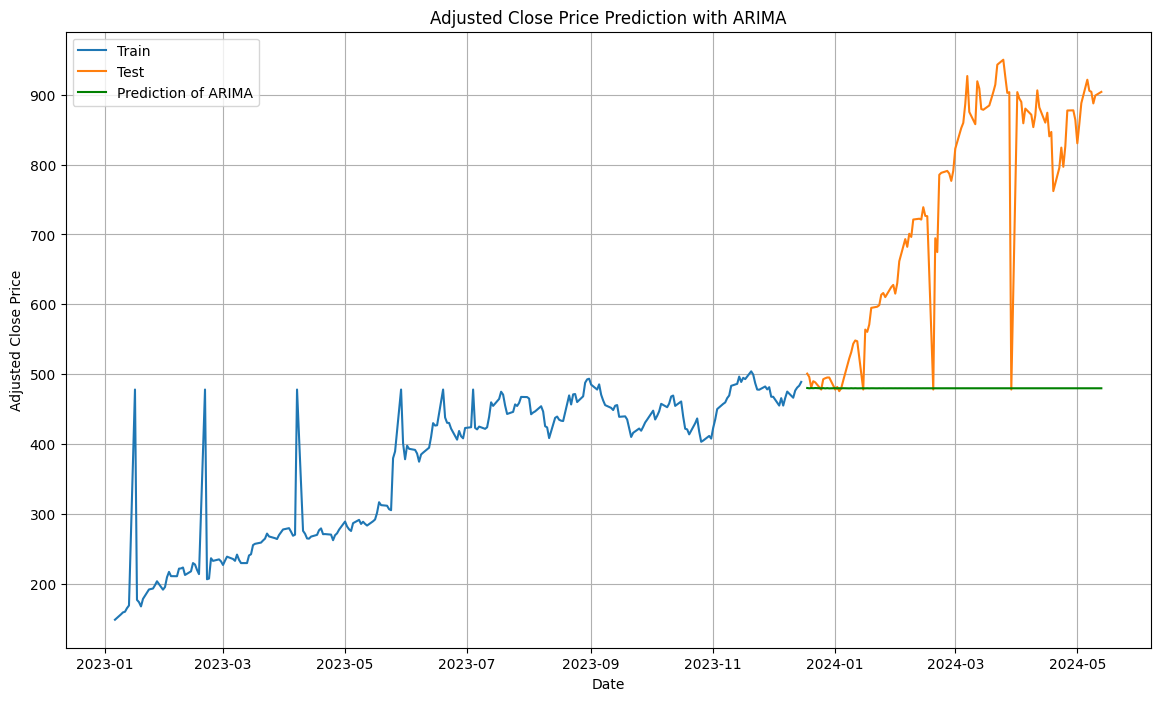

In [52]:
# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data[target], label='Train')
plt.plot(test_data.index, test_data[target], label='Test')
plt.plot(test_data.index, y_pred, label='Prediction of ARIMA', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Prediction with ARIMA')
plt.legend()
plt.grid(True)
plt.show()


The flat line in the prediction plot indicates that the ARIMA model might not be fitting well to the data.

Adfuller test

In [53]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_filled['Adj Close'])

(0.6635235652969826,
 0.9890810885540448,
 6,
 345,
 {'1%': -3.4494474563375737,
  '5%': -2.8699542285903887,
  '10%': -2.5712527305187987},
 3449.888097185996)

The results of the Augmented Dickey-Fuller (ADF) test on the Adj Close column indicate that the series is not stationary. Will try differencing

In [54]:
# Perform first order differencing
df_diff = df_filled['Adj Close'].diff().dropna()

# Check stationarity again
adf_result = adfuller(df_diff)
print('ADF Statistic (1st difference):', adf_result[0])
print('p-value (1st difference):', adf_result[1])


ADF Statistic (1st difference): -12.481990511797433
p-value (1st difference): 3.076891695651867e-23


Lets do decompose to see if seasonality is present

In [57]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00a 0:00:01


In [58]:
from pmdarima.arima import decompose
decomposed = decompose(df_filled['Adj Close'].values, 'additive', m=20) #decomposing of weekly data

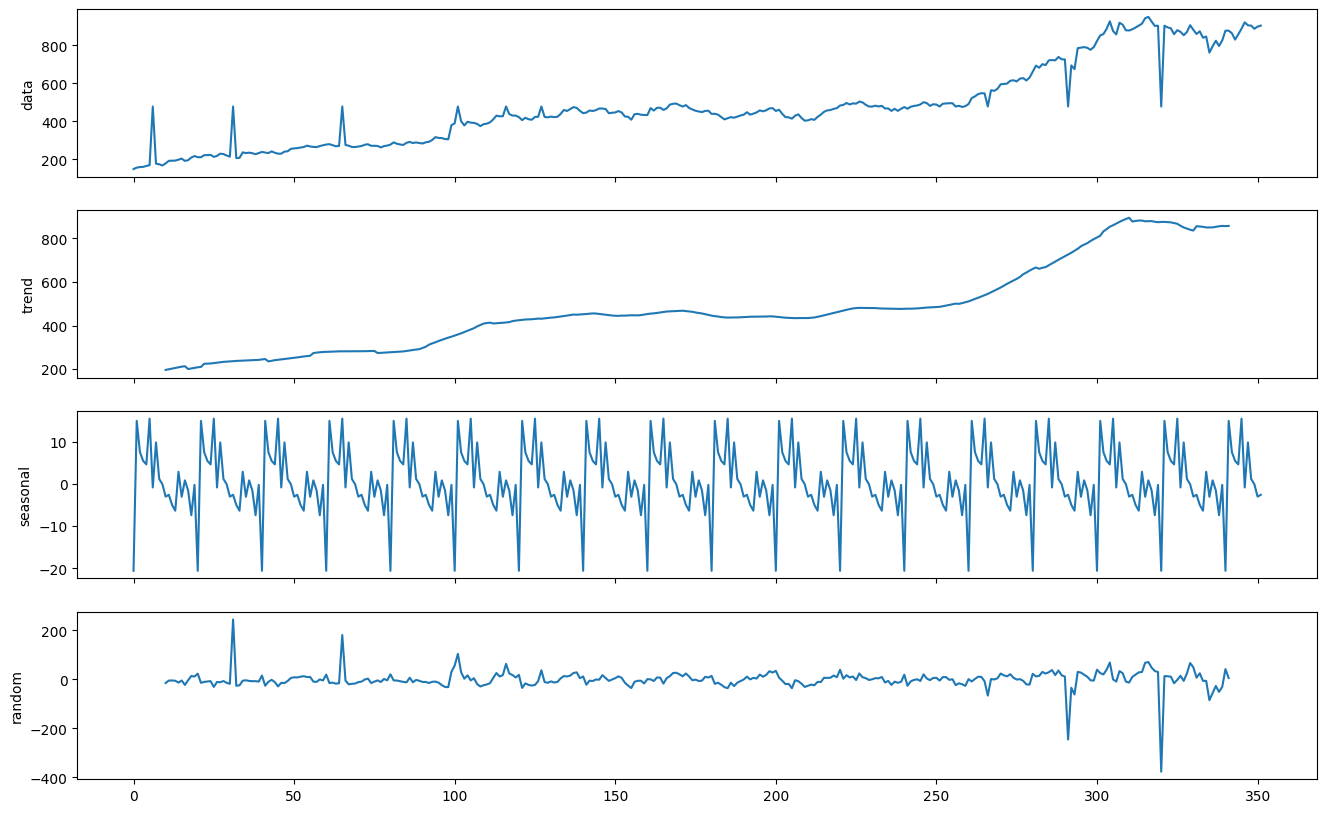

In [59]:
from pmdarima.utils import decomposed_plot
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

In [80]:
from pmdarima.arima import decompose
decomposed = decompose(df_filled['Adj Close'].values, 'additive', m=30) #decomposing of weekly data

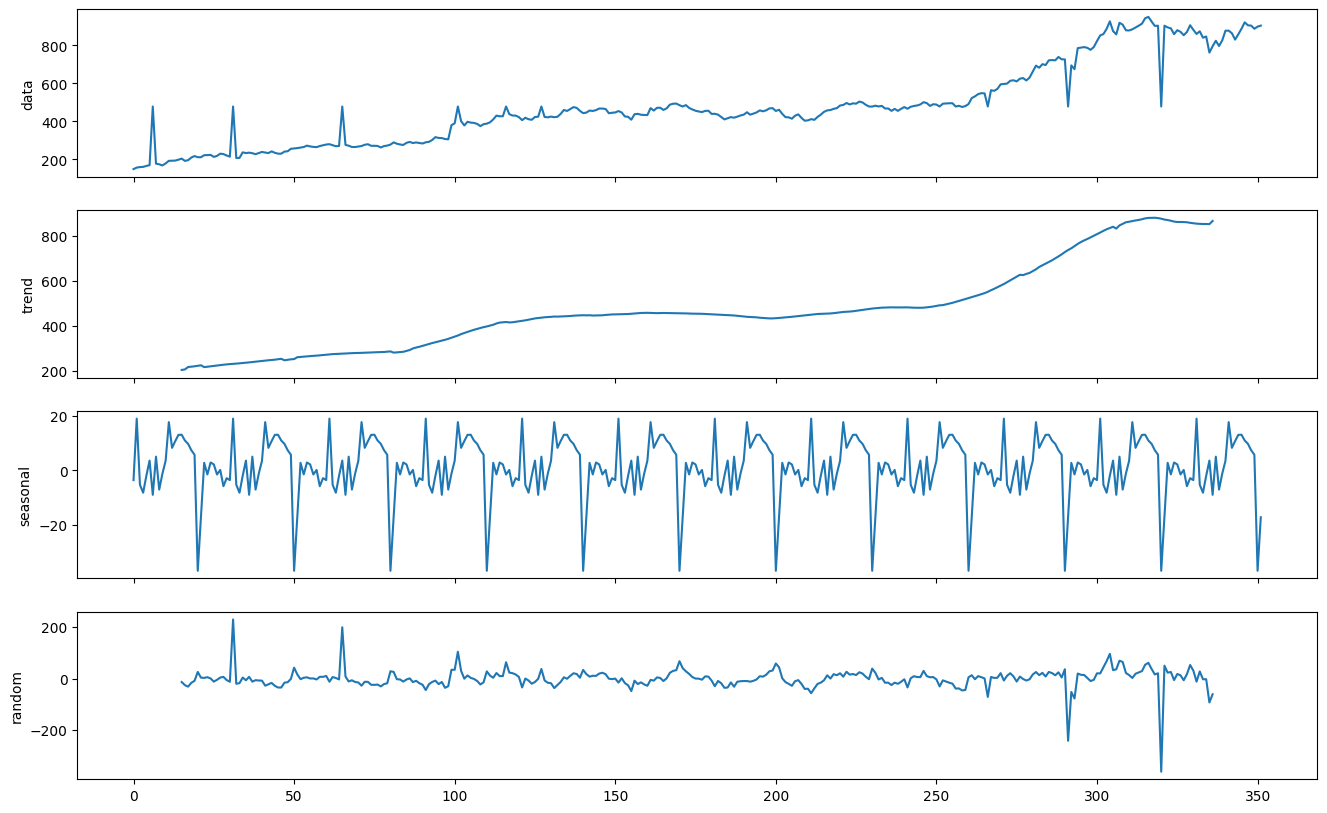

In [81]:
from pmdarima.utils import decomposed_plot
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

seasonality is definitely there

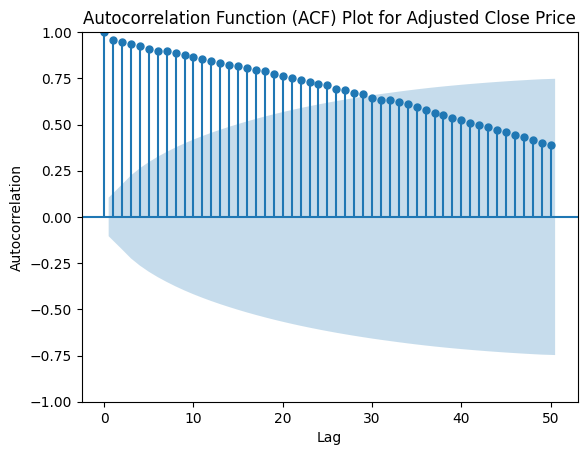

In [62]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for Adjusted Close Price
plot_acf(df_filled['Adj Close'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot for Adjusted Close Price')
plt.show()


Not stationary therefore differencing

In [63]:
# Perform 5 order differencing
df_diff_5 = df_filled['Adj Close'].diff(5).dropna()

# Check stationarity again
adf_result = adfuller(df_diff_5)
print('ADF Statistic (1st difference):', adf_result[0])
print('p-value (1st difference):', adf_result[1])


ADF Statistic (1st difference): -4.391799346104768
p-value (1st difference): 0.0003069107011634343


ARIMA with differencing =5

In [66]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define features and target variable
features = ['Open', 'Range', 'PriorDay_AdjClose', '3_Day_Avg_AdjClose(Delay)']
target = 'Adj Close'

# Split the data into training and testing sets
train_size = int(0.7 * len(df_diff_5))
train_data = df_diff_5[:train_size]
test_data = df_diff_5[train_size:]

# Train the ARIMA model on the training data
model_arima = ARIMA(train_data, order=(1, 1, 3))
model_fit = model_arima.fit()
# Forecast the values
forecast_steps = len(test_data)
y_pred = model_fit.get_forecast(steps=forecast_steps).predicted_mean

# Print the model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  242
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1267.409
Date:                Wed, 05 Jun 2024   AIC                           2544.819
Time:                        12:13:40   BIC                           2562.243
Sample:                    01-13-2023   HQIC                          2551.839
                         - 12-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9016      0.055    -16.353      0.000      -1.010      -0.794
ma.L1          0.2152      3.739      0.058      0.954      -7.112       7.543
ma.L2         -0.8028      4.532     -0.177      0.8

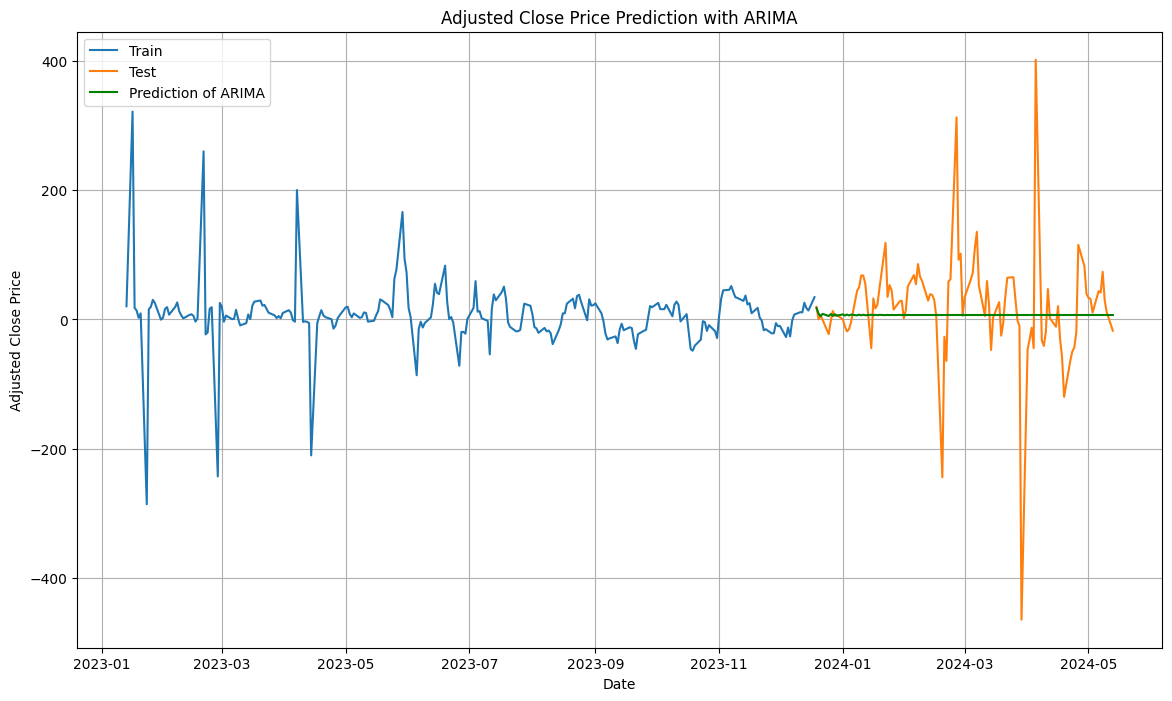

In [67]:
# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot( train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Prediction with ARIMA')
plt.legend()
plt.grid(True)
plt.show()


ARIMA DOESN'T SEEM TO WORK GOOD

Let's try SARIMAX

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model with weekly seasonality
model_sarima = SARIMAX(train_data, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 5))  # Weekly seasonality with 5 trading days

# Fit the model
model_fit_sarima = model_sarima.fit()

# Print the model summary
print(model_fit_sarima.summary())

# Forecast the test set
predictions_diff_5 = model_fit.forecast(steps=len(test_data))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35971D+00    |proj g|=  9.60268D-02

At iterate    5    f=  5.31029D+00    |proj g|=  1.23369D-02


 This problem is unconstrained.



At iterate   10    f=  5.16270D+00    |proj g|=  1.51991D-01

At iterate   15    f=  5.10377D+00    |proj g|=  6.07136D-04

At iterate   20    f=  5.10359D+00    |proj g|=  4.58727D-03

At iterate   25    f=  5.10343D+00    |proj g|=  6.61776D-04

At iterate   30    f=  5.10342D+00    |proj g|=  1.76819D-04

At iterate   35    f=  5.10342D+00    |proj g|=  1.04825D-04

At iterate   40    f=  5.10341D+00    |proj g|=  4.17717D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     54      1     0     0   4.177D-05   5.103D+00
  F =   5.1034147552279157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

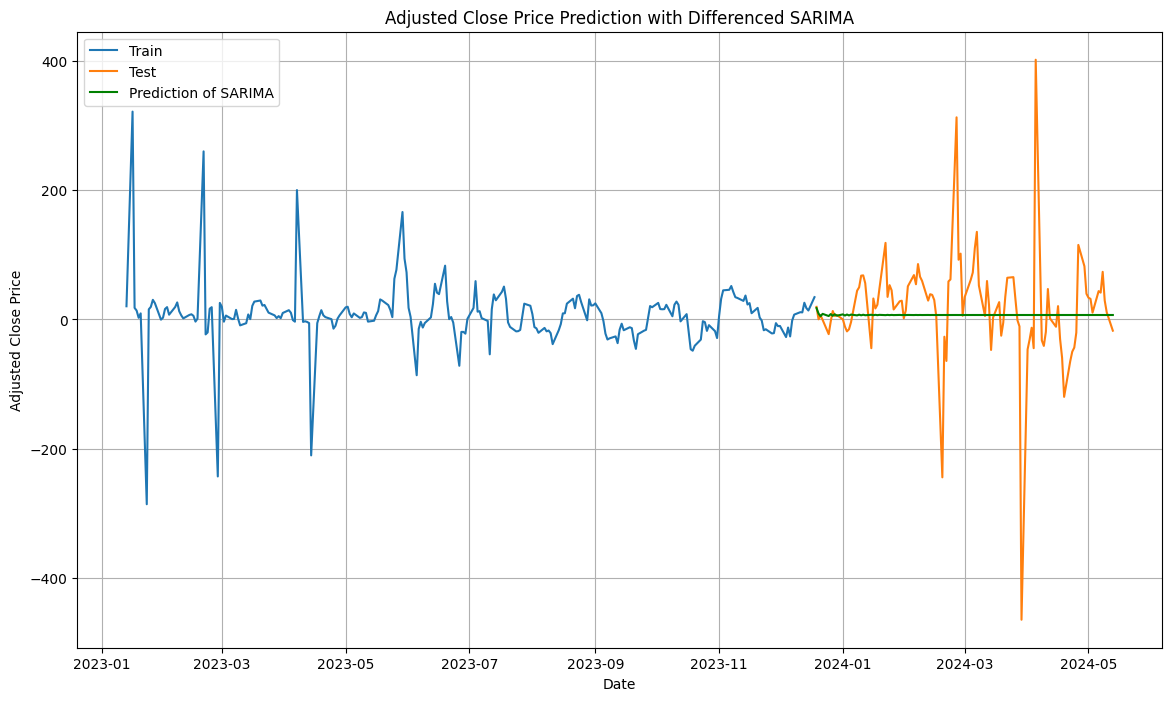

In [70]:
# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(predictions_diff_5, label='Prediction of SARIMA', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Prediction with Differenced SARIMA')
plt.legend()
plt.grid(True)
plt.show()

LETS TRY SARIMAX WITH DIFF=1

In [71]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define features and target variable
features = ['Open', 'Range', 'PriorDay_AdjClose', '3_Day_Avg_AdjClose(Delay)']
target = 'Adj Close'

# Split the data into training and testing sets
train_size_DIFF1 = int(0.7 * len(df_diff))
train_data_DIFF1 = df_diff[:train_size]
test_data_DIFF1 = df_diff[train_size:]

# Define the SARIMA model
model_sarima = SARIMAX(train_data_DIFF1, order=(5, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the SARIMA model
model_fit = model_sarima.fit(disp=False)

# Forecast the test set
predictions_diff_1 = model_fit.forecast(steps=len(test_data_DIFF1))


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


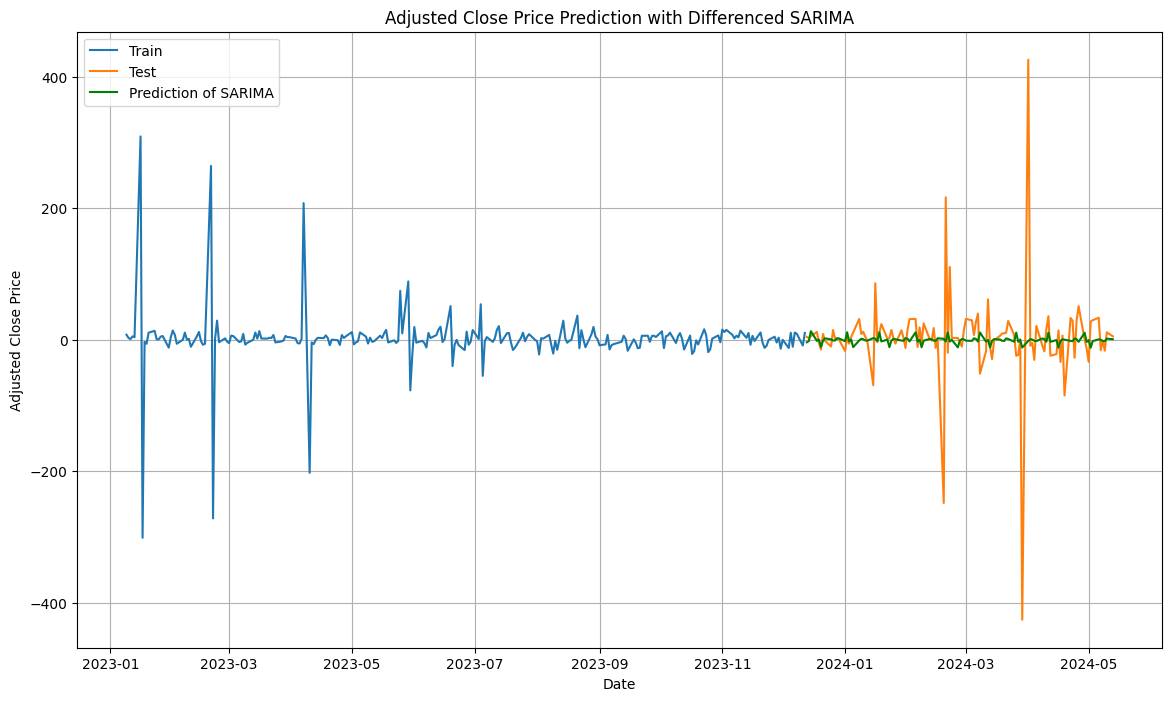

In [72]:
# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot(train_data_DIFF1, label='Train')
plt.plot(test_data_DIFF1, label='Test')
plt.plot(predictions_diff_1, label='Prediction of SARIMA', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Prediction with Differenced SARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.1 MB/s eta 0:00:0000:0100:01


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=2458.267, Time=2.60 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2547.318, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2492.555, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2451.046, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2545.569, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2449.101, Time=0.09 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=2451.052, Time=0.45 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2452.895, Time=0.98 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=2450.811, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=2450.823, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2490.738, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=2452.733, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=2451.152, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 6.239 seconds


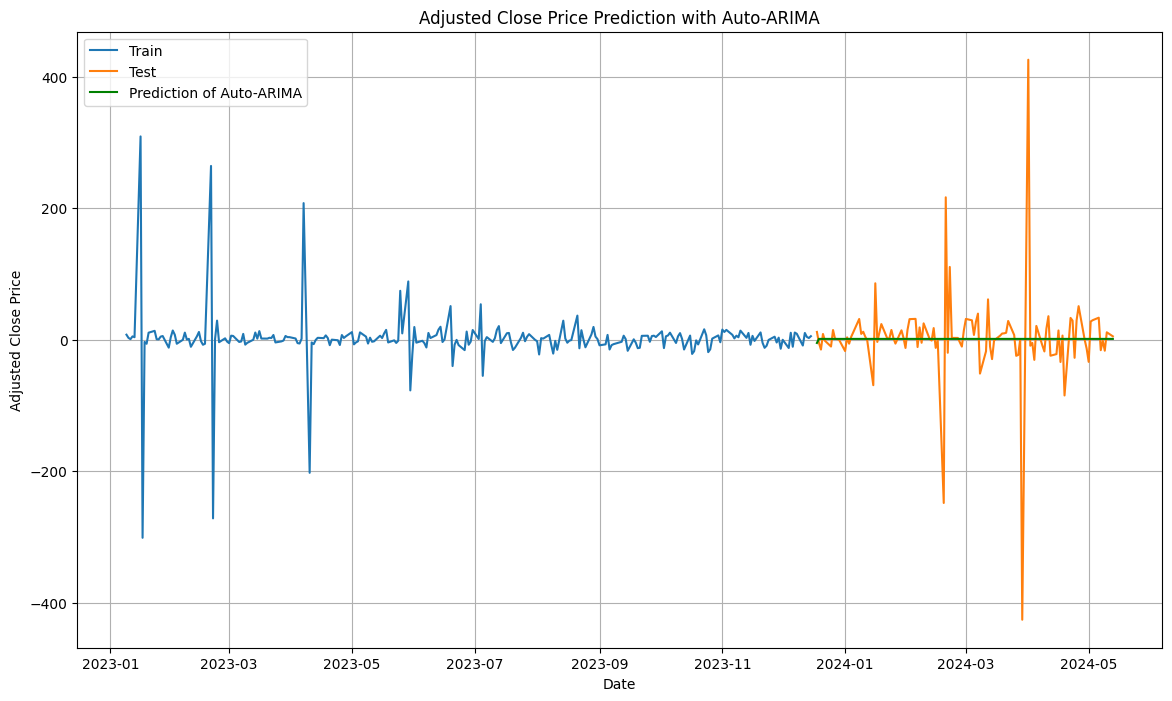

In [73]:

from pmdarima import auto_arima
import pandas as pd
import matplotlib.pyplot as plt


# Define features and target variable
target = 'Adj Close'

# Split the data into training and testing sets
train_size = int(0.7 * len(df_diff))
train_data = df_diff[:train_size]
test_data = df_diff[train_size:]

# Use auto_arima to find the best parameters
model_auto_arima = auto_arima(train_data, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Fit the model
model_auto_arima.fit(train_data)

# Forecast the test set
predictions = model_auto_arima.predict(n_periods=len(test_data))

# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(predictions, label='Prediction of Auto-ARIMA', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Prediction with Auto-ARIMA')
plt.legend()
plt.grid(True)
plt.show()


SARIMA with exogenous variables

In the standard ARIMA model, only the target variable (in this case, the 'Adj Close' price) is used for modeling and forecasting. However, you can incorporate other features (exogenous variables) into the model by using a variant called ARIMAX or SARIMAX (Seasonal ARIMA with Exogenous variables).

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


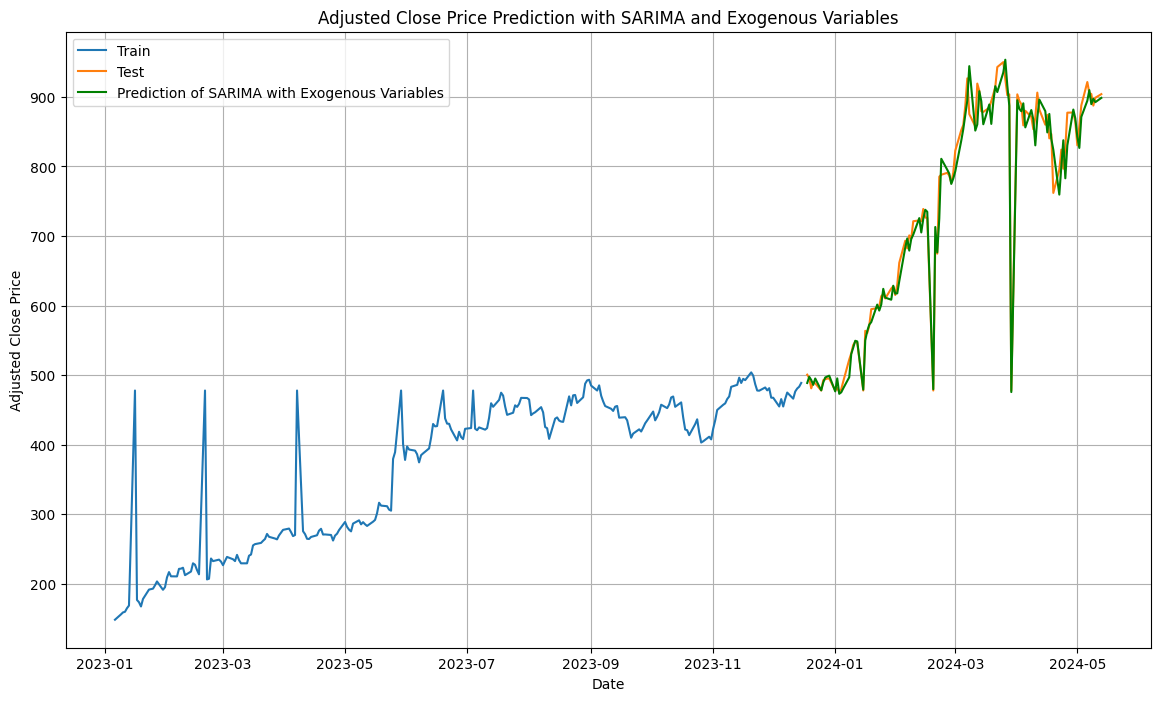

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define features and target variable
features = ['Open', 'Range', 'PriorDay_AdjClose', '3_Day_Avg_AdjClose(Delay)']
target = 'Adj Close'

# Split the data into training and testing sets
train_size = int(0.7 * len(df_filled))
train_data = df_filled[:train_size]
test_data = df_filled[train_size:]

# Extract exogenous variables for train and test sets
train_exog = train_data[features]
test_exog = test_data[features]

# Define the SARIMA model with exogenous variables
model_sarima_exog = SARIMAX(train_data[target], order=(5, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)

# Fit the SARIMA model
model_fit_exog = model_sarima_exog.fit(disp=False)

# Forecast the test set
predictions_exog = model_fit_exog.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=test_exog)

# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data[target], label='Train')
plt.plot(test_data.index, test_data[target], label='Test')
plt.plot(test_data.index, predictions_exog, label='Prediction of SARIMA with Exogenous Variables', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price Prediction with SARIMA and Exogenous Variables')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate performance metrics
mae = mean_absolute_error(test_data[target], predictions_exog)
mse = mean_squared_error(test_data[target], predictions_exog)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 14.959487511807463
Mean Squared Error (MSE): 438.8020128153929
Root Mean Squared Error (RMSE): 20.94760160055067


Exponential smoothing

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf

Prediction using ExponentialSmoothing without differencing

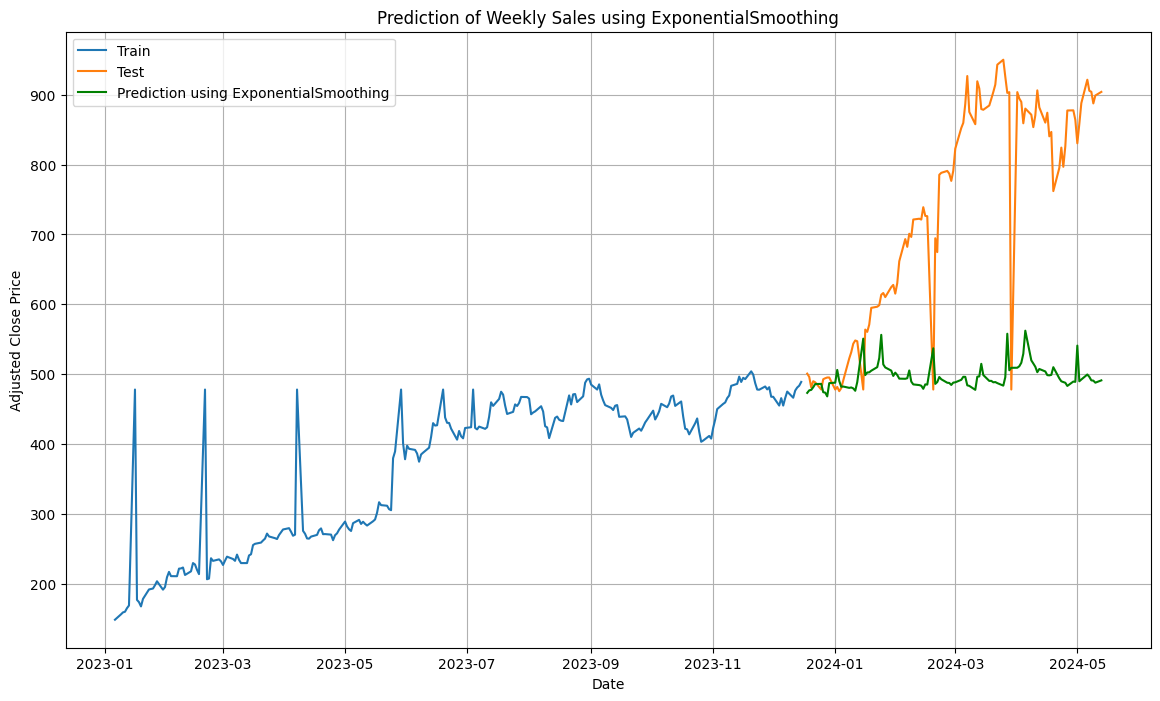

In [77]:
# model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
#                                            trend='additive',damped=True).fit() #Taking additive trend and seasonality.
# Define the Exponential Smoothing model with additive seasonal component
model_holt_winters = ExponentialSmoothing(train_data[target], seasonal_periods=52, 
                                          seasonal='additive', trend='additive', damped_trend=True).fit()


y_pred = model_holt_winters.forecast(len(test_data[target]))# Predict the test data



# Plot the train, test, and predictions
plt.figure(figsize=(14, 8))
plt.plot(train_data.index, train_data[target], label='Train')
plt.plot(test_data.index, test_data[target], label='Test')
plt.plot(test_data.index, y_pred, label='Prediction using ExponentialSmoothing', color='green')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Prediction of Weekly Sales using ExponentialSmoothing')
plt.legend()
plt.grid(True)
plt.show()

with differencing

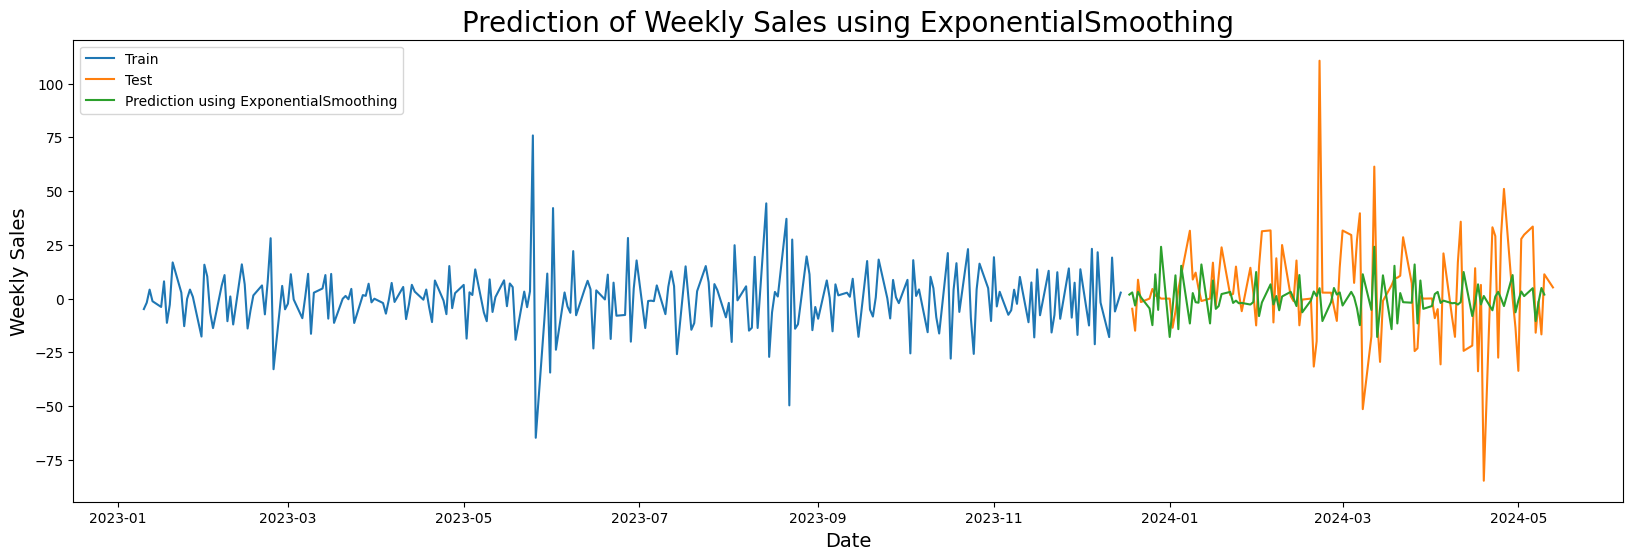

In [130]:
# model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
#                                            trend='additive',damped=True).fit() #Taking additive trend and seasonality.
# Define the Exponential Smoothing model with additive seasonal component
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=52, 
                                          seasonal='additive', trend='additive', damped_trend=True).fit()


y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()